In [105]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping


import numpy as np
import matplotlib.pyplot as plt


In [ ]:

(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_train = np.expand_dims(x_train, axis=-1)  # Dodajemo kanal za slike (28, 28, 1)
x_test = x_test.astype("float32") / 255.0
x_test = np.expand_dims(x_test, axis=-1)

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)

x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


In [ ]:

def build_generator():
    model = tf.keras.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.UpSampling2D((1, 1)),  # UpSampling factor adjusted to retain the same dimensions
        layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(1, (3, 3), padding="same", activation="sigmoid")  # Sigmoid to keep values between 0 and 1
    ])
    return model

def build_discriminator():
    model = tf.keras.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same", activation="relu"),
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid")
    ])
    return model


In [ ]:

generator = build_generator()
discriminator = build_discriminator()

discriminator.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss="binary_crossentropy", metrics=["accuracy"])

discriminator.trainable = False
gan_input = layers.Input(shape=(28, 28, 1))
generated_img = generator(gan_input)
gan_output = discriminator(generated_img)
gan = tf.keras.Model(gan_input, gan_output)
gan.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss="binary_crossentropy")


In [ ]:
def train(generator, discriminator, gan):
    epochs = 2000
    batch_size = 64
    
    for epoch in range(epochs):
      
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        real_images = x_train[idx]
        
        noise = x_train_noisy[idx]
        fake_images = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_images, np.ones((batch_size, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_images, np.zeros((batch_size, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))
        
        if epoch % 400 == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}] [G loss: {g_loss}]")

            generator.save(f"{epoch}generator_model1.h5")
            discriminator.save(f"{epoch}discriminator_model1.h5")
            gan.save(f"{epoch}gan_model1.h5")


In [110]:
# train(generator, discriminator, gan)

In [ ]:
def denoise_images(generator, noisy_images):
    denoised_images = generator.predict(noisy_images)
    return denoised_images


1/1 [==============================] - 0s 84ms/step


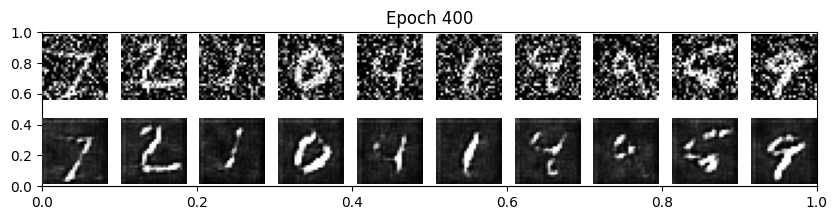

1/1 [==============================] - 0s 82ms/step


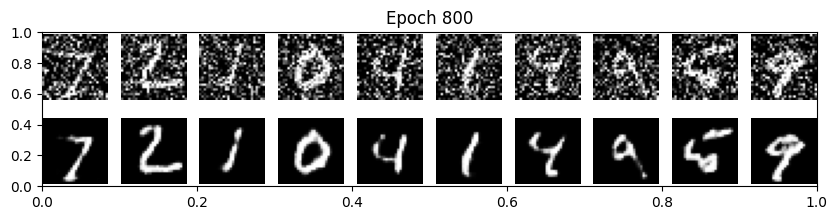

1/1 [==============================] - 0s 84ms/step


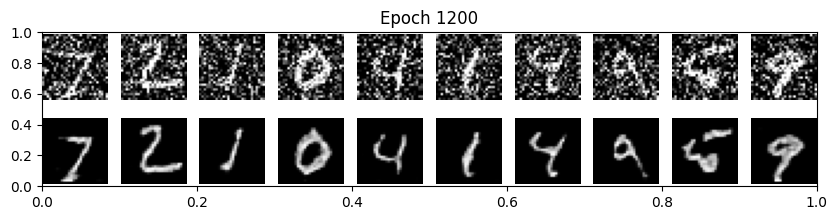

1/1 [==============================] - 0s 80ms/step


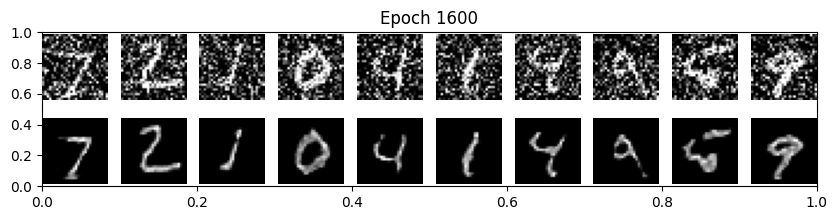

1/1 [==============================] - 0s 78ms/step


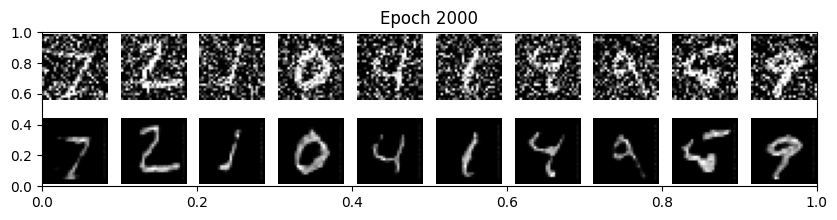

In [115]:
for i in [400, 800, 1200, 1600, 2000]:
    generator = load_model(f"{i}generator_model1.h5")
    discriminator = load_model(f"{i}discriminator_model1.h5")
    gan = load_model(f"{i}gan_model1.h5")

    generator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    gan.compile(optimizer='adam', loss='binary_crossentropy')

    denoised_images = denoise_images(generator, x_test_noisy[:10])

    plt.figure(figsize=(10, 2))
    plt.title(f"Epoch {i}")
    
    for i in range(10):
        plt.subplot(2, 10, i+1)
        plt.imshow(x_test_noisy[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
        plt.subplot(2, 10, i+11)
        plt.imshow(denoised_images[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
    plt.show()
